##Class

In [ ]:
!pip install pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210079 sha256=19a095bdb403be403cd618b050889e9cad33489ac8dcc2005618943b926a442b
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [ ]:
import numpy as np

class MinNormSolver:
    MAX_ITER = 250
    STOP_CRIT = 1e-6

    def _min_norm_element_from2(v1v1, v1v2, v2v2):
        """
        Analytical solution for min_{c} |cx_1 + (1-c)x_2|_2^2
        d is the distance (objective) optimzed
        v1v1 = <x1,x1>
        v1v2 = <x1,x2>
        v2v2 = <x2,x2>
        """
        if v1v2 >= v1v1:
            # Case: Fig 1, third column
            gamma = 0.999
            cost = v1v1
            return gamma, cost
        if v1v2 >= v2v2:
            # Case: Fig 1, first column
            gamma = 0.001
            cost = v2v2
            return gamma, cost
        # Case: Fig 1, second column
        gamma = -1.0 * ( (v1v2 - v2v2) / (v1v1+v2v2 - 2*v1v2) )
        cost = v2v2 + gamma*(v1v2 - v2v2)
        return gamma, cost

    def _min_norm_2d(vecs, dps):
        """
        Find the minimum norm solution as combination of two points
        This solution is correct if vectors(gradients) lie in 2D
        ie. min_c |\sum c_i x_i|_2^2 st. \sum c_i = 1 , 1 >= c_1 >= 0 for all i, c_i + c_j = 1.0 for some i, j
        """
        dmin = 1e8
        for i in range(len(vecs)):
            for j in range(i+1,len(vecs)):
                if (i,j) not in dps:
                    dps[(i, j)] = 0.0
                    dps[(i,j)] = np.dot(vecs[i], vecs[j])
                    dps[(j, i)] = dps[(i, j)]
                if (i,i) not in dps:
                    dps[(i, i)] = 0.0
                    dps[(i,i)] = np.dot(vecs[i], vecs[i])
                if (j,j) not in dps:
                    dps[(j, j)] = 0.0
                    dps[(j, j)] = np.dot(vecs[j], vecs[j])
                c,d = MinNormSolver._min_norm_element_from2(dps[(i,i)], dps[(i,j)], dps[(j,j)])
                if d < dmin:
                    dmin = d
                    sol = [(i,j),c,d]
        return sol, dps

    def _projection2simplex(y):
        """
        Given y, it solves argmin_z |y-z|_2 st \sum z = 1 , 1 >= z_i >= 0 for all i
        """
        m = len(y)
        sorted_y = np.flip(np.sort(y), axis=0)
        tmpsum = 0.0
        tmax_f = (np.sum(y) - 1.0)/m
        for i in range(m-1):
            tmpsum+= sorted_y[i]
            tmax = (tmpsum - 1)/ (i+1.0)
            if tmax > sorted_y[i+1]:
                tmax_f = tmax
                break
        return np.maximum(y - tmax_f, np.zeros(y.shape))

    def _next_point(cur_val, grad, n):
        proj_grad = grad - ( np.sum(grad) / n )
        tm1 = -1.0*cur_val[proj_grad<0]/proj_grad[proj_grad<0]
        tm2 = (1.0 - cur_val[proj_grad>0])/(proj_grad[proj_grad>0])

        skippers = np.sum(tm1<1e-7) + np.sum(tm2<1e-7)
        t = 1
        if len(tm1[tm1>1e-7]) > 0:
            t = np.min(tm1[tm1>1e-7])
        if len(tm2[tm2>1e-7]) > 0:
            t = min(t, np.min(tm2[tm2>1e-7]))

        next_point = proj_grad*t + cur_val
        next_point = MinNormSolver._projection2simplex(next_point)
        return next_point

    def find_min_norm_element(vecs):
        """
        Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
        as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
        It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
        Hence, we find the best 2-task solution, and then run the projected gradient descent until convergence
        """
        # Solution lying at the combination of two points
        dps = {}
        init_sol, dps = MinNormSolver._min_norm_2d(vecs, dps)

        n=len(vecs)
        sol_vec = np.zeros(n)
        sol_vec[init_sol[0][0]] = init_sol[1]
        sol_vec[init_sol[0][1]] = 1 - init_sol[1]

        if n < 3:
            # This is optimal for n=2, so return the solution
            return sol_vec , init_sol[2]

        iter_count = 0

        grad_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                grad_mat[i,j] = dps[(i, j)]

        while iter_count < MinNormSolver.MAX_ITER:
            grad_dir = -1.0*np.dot(grad_mat, sol_vec)
            new_point = MinNormSolver._next_point(sol_vec, grad_dir, n)
            # Re-compute the inner products for line search
            v1v1 = 0.0
            v1v2 = 0.0
            v2v2 = 0.0
            for i in range(n):
                for j in range(n):
                    v1v1 += sol_vec[i]*sol_vec[j]*dps[(i,j)]
                    v1v2 += sol_vec[i]*new_point[j]*dps[(i,j)]
                    v2v2 += new_point[i]*new_point[j]*dps[(i,j)]
            nc, nd = MinNormSolver._min_norm_element_from2(v1v1, v1v2, v2v2)
            new_sol_vec = nc*sol_vec + (1-nc)*new_point
            change = new_sol_vec - sol_vec
            if np.sum(np.abs(change)) < MinNormSolver.STOP_CRIT:
                return sol_vec, nd
            sol_vec = new_sol_vec
        return sol_vec, nd


In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.indicators.hv import Hypervolume

hv = Hypervolume(ref_point=np.array([1, 1]))

#VD1

In [ ]:
import numpy as np
from autograd import grad
import autograd.numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def f1(x):
    return (x[0]**2+x[1]**2+3)/(1+2*x[0]+8*x[1])
def f2(x):
    return (x[0]**2+x[1]**2+3)/(1+2*x[1]+8*x[0])

def g1(x):
    return x[0]**2+2*x[1]*x[0]-4
def g2(x):
    return x[0]
def g3(x):
    return x[1]

f1_dx = grad(f1)
f2_dx = grad(f2)
g1_dx = grad(g1)
g2_dx = grad(g2)
g3_dx = grad(g3)

cons = ({'type': 'ineq',
          'fun' : lambda x: np.array([g1(x)])},
         {'type': 'ineq',
          'fun' : lambda x: np.array([g2(x)])},
          {'type': 'ineq',
          'fun' : lambda x: np.array([g3(x)])})

def rosen(x,y):
    """The Rosenbrock function"""
    return np.sqrt(np.sum((x-y)**2))

def find_min(y,n):
    x = np.random.rand(1,n).tolist()[0]
    res = minimize(rosen, x, args=(y), jac="2-point",
                constraints=cons,method='SLSQP', options={'disp': False})
    return res.x

In [ ]:
import autograd.numpy as np
from autograd import grad

from matplotlib import pyplot as plt

# use autograd to calculate the gradient
import autograd.numpy as np
from autograd import grad
from scipy.linalg import norm
from matplotlib import pyplot as plt

def get_d_paretomtl(grads,value, constraint,weights,i):
    # calculate the gradient direction for Pareto MTL
    nobj, dim = grads.shape

    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight

    # solve QP
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0

    test = np.concatenate((grads, np.dot(w[idx],grads)), axis = 0)

    if test.ndim == constraint.ndim:
      vec =  np.concatenate((test, constraint), axis = 0)
    else:
      vec = test

    vec = vec/norm(vec)

    # use MinNormSolver to solve QP
    sol, nd = MinNormSolver.find_min_norm_element(vec)

    # reformulate ParetoMTL as linear scalarization method, return the weights
    weight0 =  sol[0] + np.sum(np.array([sol[j] * w[idx][j - 2,0] for j in np.arange(2,2 + np.sum(idx))]))
    weight1 = sol[1] + np.sum(np.array([sol[j] * w[idx][j - 2,1] for j in np.arange(2,2 + np.sum(idx))]))

    num_cons = len(constraint)
    if num_cons != 0:
      weight_cons = sol[-num_cons:]
      weight = np.array([weight0] + [weight1] + weight_cons.tolist())
    else:
      weight = np.stack([weight0, weight1])
    return weight


def get_d_paretomtl_init(grads,value,constraint, weights,i):
    # calculate the gradient direction for Pareto MTL initialization
    nobj, dim = grads.shape

    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight

    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0

    if np.sum(idx) <= 0:
        return np.zeros(nobj)
    if np.sum(idx) == 1:
        sol = np.ones(1)
    else:
        test = np.dot(w[idx],grads)
        if constraint.ndim == test.ndim:
          vec =  np.concatenate((test, constraint), axis = 0)
        else:
          vec = test
        vec = vec/norm(vec)

        sol, nd = MinNormSolver.find_min_norm_element(vec)

    # calculate the weights
    weight0 =  np.sum(np.array([sol[j] * w[idx][j ,0] for j in np.arange(0, np.sum(idx))]))
    weight1 =  np.sum(np.array([sol[j] * w[idx][j ,1] for j in np.arange(0, np.sum(idx))]))

    num_cons = len(constraint)
    if num_cons != 0:
      weight_cons = sol[-num_cons:]
      weight = np.array([weight0] + [weight1] + weight_cons.tolist())
    else:
      weight = np.stack([weight0, weight1])
    return weight

def concave_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f1(x), f2(x)]), np.stack([f1_dx(x), f2_dx(x)])

### create the ground truth Pareto front ###
def create_pf_concave():
    ps = np.linspace(0, 10, 100)
    pf = []

    for x1 in ps:
      for x2 in ps:
        if 4-x1**2-2*x1*x2<=0:
          x = np.array([x1, x2])
          f, f_dx = concave_fun_eval(x)
          pf.append(f)

    pf = np.array(pf)

    return pf

def circle_points(r, n):
    # generate evenly distributed preference vector
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 0.5 * np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

def circle_points2(K, min_angle=None, max_angle=None):
    # generate evenly distributed preference vector
    ang0 = np.pi / 30. if min_angle is None else min_angle
    ang1 = np.pi * 8 / 20. if max_angle is None else max_angle
    angles = np.linspace(ang0, ang1, K, endpoint=True)
    x = np.cos(angles)
    y = np.sin(angles)
    return np.c_[x, y]


# calculate the gradients using autograd
f1_dx = grad(f1)
f2_dx = grad(f2)


def pareto_mtl_search(ref_vecs,i, t_iter = 1000, n_dim = 2, step_size = 1, sigma = 1, kappa = 0.95, eps = 1e-6, count_check = 10):
    """
    Pareto MTL
    """

    # randomly generate one solution
    x = np.random.uniform(0, 2, n_dim)

    f_all = []
    x_all = []
    df_all = []

    # # # find the initial solution
    for t in range(int(t_iter * 0.2)):
        f, f_dx = concave_fun_eval(x)
        # f, f_dx = convex_fun_eval(x)
        constraint = []
        value_set = [[g1(x),g1_dx(x)], [g2(x),g2_dx(x)], [g3(x),g3_dx(x)]]

        for g_value in value_set:
          if g_value[0]<=eps and g_value[0]>=-eps:
            constraint.append(g_value[1])
        constraint = np.array(constraint)
        weights =  get_d_paretomtl_init(f_dx, f, constraint, ref_vecs,i)

        if len(weights) > len(f_dx):
          direction_descent = -np.dot(weights[0:len(f_dx)].T,f_dx) - np.dot(weights[len(f_dx):].T, constraint)
        else:
          direction_descent = -np.dot(weights.T,f_dx)

        x = x + step_size * direction_descent
        # x = find_min(x, 2)
        x_all.append(x)

    count = 0
    # find the Pareto optimal solution
    for t in range(int(t_iter * 0.8)):
        #f, f_dx = convex_fun_eval(x)
        f, f_dx = concave_fun_eval(x)
        f_all.append(f)
        df_all.append(f_dx)
        constraint = []
        value_set = [[g1(x),g1_dx(x)], [g2(x),g2_dx(x)], [g3(x),g3_dx(x)]]

        for g_value in value_set:
          if g_value[0]<=eps and g_value[0]>=-eps:
            constraint.append(g_value[1])
        constraint = np.array(constraint)

        weights =  get_d_paretomtl(f_dx, f, constraint, ref_vecs, i)

        if len(weights) > len(f_dx):
          direction_descent = -np.dot(weights[0:len(f_dx)].T,f_dx) - np.dot(weights[len(f_dx):].T, constraint)
          x = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k
          #x_next = find_min(x_next, n_dim)
          f_after, f_dx_after = concave_fun_eval(x)
          #f_after, f_dx_after = convex_fun_eval(x_next)

          if np.all(f_after <= f + sigma*np.dot(f_dx, step_size * direction_descent)):
            step_size *= 1
          else:
            step_size *= kappa
        else:
          direction_descent = -np.dot(weights.T,f_dx)
          x = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k
          #x_next = find_min(x_next, n_dim)
          f_after, f_dx_after = concave_fun_eval(x)
          #f_after, f_dx_after = convex_fun_eval(x_next)

          if np.all(f_after <= f + sigma*np.dot(f_dx, step_size * direction_descent)):
            step_size *= 1
          else:
            step_size *= kappa

        if -1/2*norm(direction_descent)**2 >= -eps and -1/2*norm(direction_descent)**2 <= eps:
          break

        # x = x + step_size * direction_descent
        #x = find_min(x, n_dim)
        x_all.append(x)

    return x, f, x_all, f_all, df_all

0
1
2
3
4
5
6
7
8
9


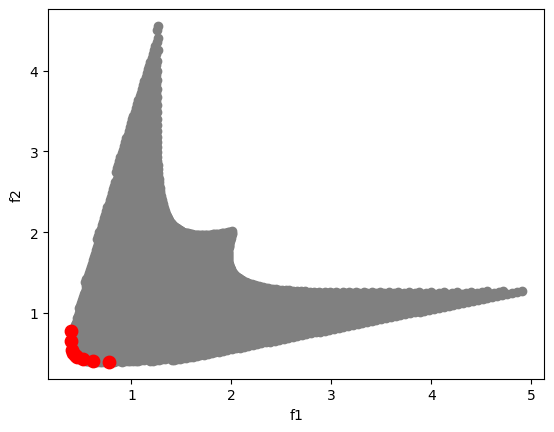

In [ ]:
pf = create_pf_concave()
f_value_list = []
x_value_list = []
num = 10

#weights = circle_points([1], [num])[0]
weights = circle_points2(num)

for i in range(num):

    print(i)

    x, f, x_all, f_all, df_all = pareto_mtl_search(ref_vecs = weights,i = i)

    # x = find_min(x, 2)
    # if x[0] >= 0  and x[1] >= 0 and x[0]**2 +2 *x[0]*x[1] -4 >=0:
    f_value_list.append(f)
    x_value_list.append(x)

f_value = np.array(f_value_list)
plt.xlabel("f1")
plt.ylabel("f2")
plt.scatter(pf[:,0],pf[:,1], c = 'gray')
plt.scatter(f_value[:,0], f_value[:,1], c = 'r', s = 80)
plt.show()

#Version 2 VD1

In [ ]:
import autograd.numpy as np
from autograd import grad

from matplotlib import pyplot as plt

# use autograd to calculate the gradient
import autograd.numpy as np
from autograd import grad
from scipy.linalg import norm
from matplotlib import pyplot as plt

def get_d_moomtl(grads, constraint):
    """
    calculate the gradient direction for MOO-MTL
    """

    nobj, dim = grads.shape

    if constraint.ndim == grads.ndim:
      vec =  np.concatenate((grads, constraint), axis = 0)
    else:
      vec = grads
    vec = vec/norm(vec)

    sol, nd = MinNormSolver.find_min_norm_element(vec)

    return sol


def circle_points(r, n):
    # generate evenly distributed preference vector
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 0.5 * np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

def circle_points2(K, min_angle=None, max_angle=None):
    # generate evenly distributed preference vector
    ang0 = np.pi / 30. if min_angle is None else min_angle
    ang1 = np.pi * 8 / 20. if max_angle is None else max_angle
    angles = np.linspace(ang0, ang1, K, endpoint=True)
    x = np.cos(angles)
    y = np.sin(angles)
    return np.c_[x, y]


# calculate the gradients using autograd
f1_dx = grad(f1)
f2_dx = grad(f2)


def moo_mtl_search(ref_vecs,i,t_iter = 1000, n_dim = 2, step_size = 1, sigma = 1, kappa = 0.85, eps = 0.01, count_check = 10):
    """
    Pareto MTL
    """

    # randomly generate one solution
    x = np.random.uniform(0, 1, n_dim)
    x = find_min(x, 2)
    f_all = []
    x_all = []
    df_all = []

    # find the Pareto optimal solution
    for t in range(t_iter):
        #f, f_dx = convex_fun_eval(x)
        f, f_dx = concave_fun_eval(x)
        f_all.append(f)
        df_all.append(f_dx)
        constraint = []
        value_set = [[g1(x),g1_dx(x)], [g2(x),g2_dx(x)], [g3(x),g3_dx(x)]]
        for f_value in value_set:
          if f_value[0]<=eps:
            constraint.append(-f_value[1])
        constraint = np.array(constraint)
        weights =  get_d_moomtl(f_dx, constraint)

        if len(weights) > len(f_dx):
          direction_descent = -np.dot(weights[0:len(f_dx)].T,f_dx).flatten() - np.dot(weights[len(f_dx):].T, constraint).flatten()
        else:
          direction_descent = -np.dot(weights.T,f_dx).flatten()
        if -1/2*norm(direction_descent)**2 >= -0.01 or -1/2*norm(direction_descent)**2 <= 0.01:
          break
        x_next = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k
        #x_next = find_min(x_next, n_dim)
        f_after, f_dx_after = concave_fun_eval(x_next)
        #f_after, f_dx_after = convex_fun_eval(x_next)

        if np.all(f_after <= f + sigma*np.dot(f_dx, step_size * direction_descent)):
          step_size *= 1
        else:
          step_size *= kappa

        x = x + step_size * direction_descent
        #x = find_min(x, n_dim)
        x_all.append(x)

    return x, f, x_all, f_all, df_all


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


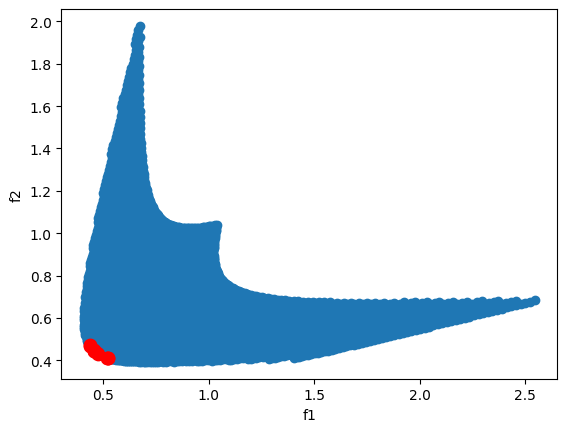

In [ ]:
def concave_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f1(x), f2(x)]), np.stack([f1_dx(x), f2_dx(x)])

### create the ground truth Pareto front ###
def create_pf_concave():
    ps = np.linspace(0, 5, 100)
    pf = []

    for x1 in ps:
      for x2 in ps:
        if 4-x1**2-2*x1*x2<=0:
          x = np.array([x1, x2])
          f, f_dx = concave_fun_eval(x)
          pf.append(f)

    pf = np.array(pf)

    return pf

# pf = create_pf_concave()
f_value_list = []
x_value_list = []
num = 20

weights = circle_points([1], [num])[0]
#weights = circle_points2(num)

for i in range(num):

    print(i)

    x, f, x_all, f_all, df_all = moo_mtl_search(ref_vecs = weights,i = i)

    x = find_min(x, 2)
    if x[0] >= 0  and x[1] >= 0 and x[0]**2 +2 *x[0]*x[1] -4 >=0:
      f_value_list.append(f)
      x_value_list.append(x)

f_value = np.array(f_value_list)
plt.xlabel("f1")
plt.ylabel("f2")
plt.scatter(pf[:,0],pf[:,1])
plt.scatter(f_value[:,0], f_value[:,1], c = 'r', s = 80)
plt.show()

#VD2

In [ ]:
# use autograd to calculate the gradient
import autograd.numpy as np
from autograd import grad
from math import e
from matplotlib import pyplot as plt
from time import time

def get_d_paretomtl(grads,value,weights,i):
    # calculate the gradient direction for Pareto MTL
    nobj, dim = grads.shape

    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight


    # solve QP
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0

    vec =  np.concatenate((grads, np.dot(w[idx],grads)), axis = 0)

    # use MinNormSolver to solve QP
    sol, nd = MinNormSolver.find_min_norm_element(vec)


    # reformulate ParetoMTL as linear scalarization method, return the weights
    weight0 =  sol[0] + np.sum(np.array([sol[j] * w[idx][j - 2,0] for j in np.arange(2,2 + np.sum(idx))]))
    weight1 = sol[1] + np.sum(np.array([sol[j] * w[idx][j - 2,1] for j in np.arange(2,2 + np.sum(idx))]))
    weight = np.stack([weight0,weight1])

    return weight


def get_d_paretomtl_init(grads,value,weights,i):
    # calculate the gradient direction for Pareto MTL initialization
    nobj, dim = grads.shape

    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight

    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0

    if np.sum(idx) <= 0:
        return np.zeros(nobj)
    if np.sum(idx) == 1:
        sol = np.ones(1)
    else:
        vec =  np.dot(w[idx],grads)
        sol, nd = MinNormSolver.find_min_norm_element(vec)

    # calculate the weights
    weight0 =  np.sum(np.array([sol[j] * w[idx][j ,0] for j in np.arange(0, np.sum(idx))]))
    weight1 =  np.sum(np.array([sol[j] * w[idx][j ,1] for j in np.arange(0, np.sum(idx))]))
    weight = np.stack([weight0,weight1])


    return weight

def pareto_mtl_search_proposed(ref_vecs,i,t_iter = 300, n_dim = 20, step_size = 1, sigma = 0.1, eps = 1e-8, kappa = 0.95):
    """
    Pareto MTL
    """

    # randomly generate one solution
    x = np.random.uniform(-0.5,0.5,n_dim)
    #x = (np.random.rand(1,2)).tolist()[0]
    #x = np.random.uniform(-2,0,n_dim)
    #print(x.shape)
    # find the initial solution
    for t in range(int(t_iter * 0.2)):
        f, f_dx = concave_fun_eval(x)
        #f, f_dx = convex_fun_eval(x)

        weights =  get_d_paretomtl_init(f_dx,f,ref_vecs,i)

        x = x - step_size * np.dot(weights.T,f_dx)
    count =0
    # find the Pareto optimal solution
    for t in range(int(t_iter * 0.8)):
        #f, f_dx = convex_fun_eval(x)
        f, f_dx = concave_fun_eval(x)

        weights =  get_d_paretomtl(f_dx,f,ref_vecs,i)

        direction_descent = -np.dot(weights.T,f_dx)

        x = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k

        f_after, f_dx_after = concave_fun_eval(x)
        #f_after, f_dx_after = convex_fun_eval(x_next)

        if np.all(f_after <= f + sigma*np.dot(f_dx, step_size * direction_descent)):
            step_size = step_size
            count+=1
        else:
            step_size *= kappa
        if -1/2*np.linalg.norm(direction_descent, np.inf)**2 >= -eps and -1/2*np.linalg.norm(direction_descent, np.inf)**2 <= eps:
          break

    return x, f

def pareto_mtl_search(ref_vecs,i, t_iter = 300, n_dim = 20, step_size = 1):
    """
    Pareto MTL
    """

    # randomly generate one solution
    x = np.random.uniform(-0.5,0.5,n_dim)
    #x = (np.random.rand(1,2)).tolist()[0]
    #x = np.random.uniform(-2,0,n_dim)
    #print(x.shape)
    # find the initial solution
    for t in range(int(t_iter * 0.2)):
        f, f_dx = concave_fun_eval(x)
        #f, f_dx = convex_fun_eval(x)

        weights =  get_d_paretomtl_init(f_dx,f,ref_vecs,i)

        x = x - step_size * np.dot(weights.T,f_dx).flatten()

    # find the Pareto optimal solution
    for t in range(int(t_iter * 0.8)):
        #f, f_dx = convex_fun_eval(x)
        f, f_dx = concave_fun_eval(x)

        weights =  get_d_paretomtl(f_dx,f,ref_vecs,i)

        direction_descent = -np.dot(weights.T,f_dx).flatten()

        x = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k

    return x, f

In [ ]:
### the synthetic multi-objective problem ###
def f1(x):

    n = len(x)

    sum1 = np.sum([(x[i] - 1.0/np.sqrt(n)) ** 2 for i in range(n)])

    f1 = 1 - e**(- sum1)
    return f1

def f2(x):

    n = len(x)

    sum2 = np.sum([(x[i] + 1.0/np.sqrt(n)) ** 2 for i in range(n)])

    f2 = 1 - e**(- sum2)

    return f2

def f3(x):
    #2 dims
    return 1/25*x[0]**2+1/100*(x[1]-9/2)**2
def f4(x):
    return 1/25*x[1]**2+1/100*(x[0]-9/2)**2

# calculate the gradients using autograd
f1_dx = grad(f1)
f2_dx = grad(f2)
f3_dx = grad(f3)
f4_dx = grad(f4)

def concave_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f1(x), f2(x)]), np.stack([f1_dx(x), f2_dx(x)])

def convex_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f3(x), f4(x)]), np.stack([f3_dx(x), f4_dx(x)])

In [ ]:
def circle_points(r, n):
    # generate evenly distributed preference vector
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 0.5 * np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles


### create the ground truth Pareto front ###
def create_pf_concave():
    ps = np.linspace(-1/np.sqrt(2),1/np.sqrt(2))
    pf = []

    for x1 in ps:
        #generate solutions on the Pareto front:
        x = np.array([x1,x1])

        f, f_dx = concave_fun_eval(x)

        pf.append(f)

    pf = np.array(pf)

    return pf


def create_pf1():
    ps1 = np.linspace(-6, 0, num=500)
    pf = []
    for x1 in ps1:
        x = [9*x1/(2*x1-8),9/(2-8*x1)]
        f = [f3(x), f4(x)]
        #print(f)
        pf.append(f)
    pf = np.array(pf)
    return pf

0
1
2
3
4
5
6
7
8
9


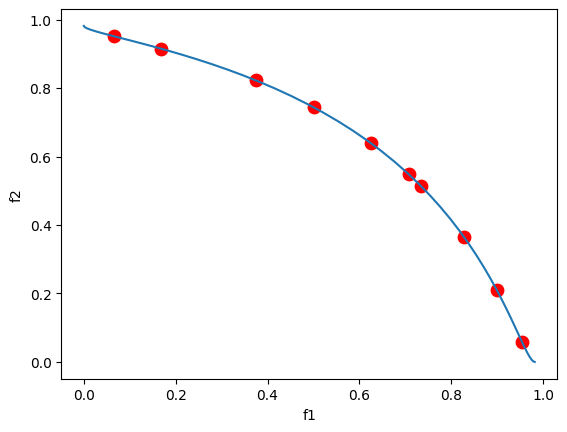

In [ ]:
pf = create_pf_concave()
f_value_list = []
x_value_list = []
num = 10

weights = circle_points([1], [num])[0]
#weights = circle_points2(num)

for i in range(num):

    print(i)

    x, f = pareto_mtl_search(ref_vecs = weights, i = i)

    f_value_list.append(f)
    x_value_list.append(x)

f_value = np.array(f_value_list)
plt.xlabel("f1")
plt.ylabel("f2")
plt.plot(pf[:,0],pf[:,1])
plt.scatter(f_value[:,0], f_value[:,1], c = 'r', s = 80)
plt.show()

Test case  0.0
Time PMTL Test case 0.0 258.1702687740326  s
Time proposed Test case 0.0 176.2773425579071  s
Hyper volume:  1.4986866381661283
Hyper volume Proposed:  1.5659360151828072


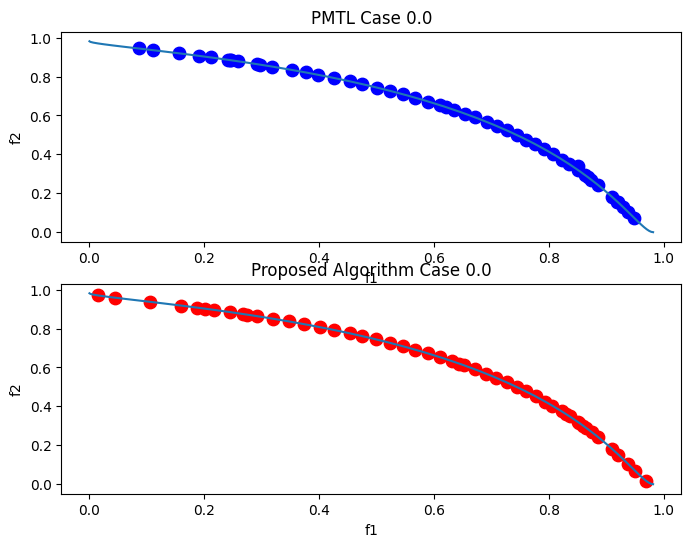

Test case  1.0
Time PMTL Test case 1.0 231.7457718849182  s
Time proposed Test case 1.0 184.1716504096985  s
Hyper volume:  1.504434867356641
Hyper volume Proposed:  1.5322261278846456


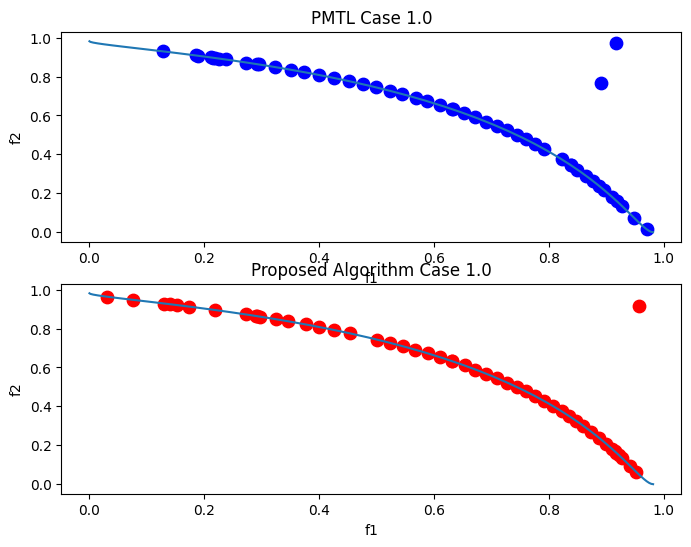

Test case  2.0
Time PMTL Test case 2.0 284.4931118488312  s
Time proposed Test case 2.0 236.98095870018005  s
Hyper volume:  1.508636074620449
Hyper volume Proposed:  1.4432018506213808


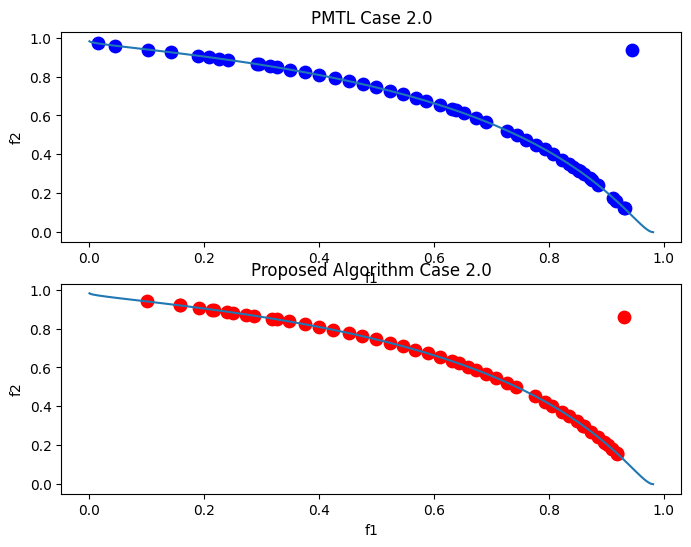

Test case  3.0
Time PMTL Test case 3.0 201.25233101844788  s
Time proposed Test case 3.0 219.1392047405243  s
Hyper volume:  1.5656517068143365
Hyper volume Proposed:  1.5096252021447554


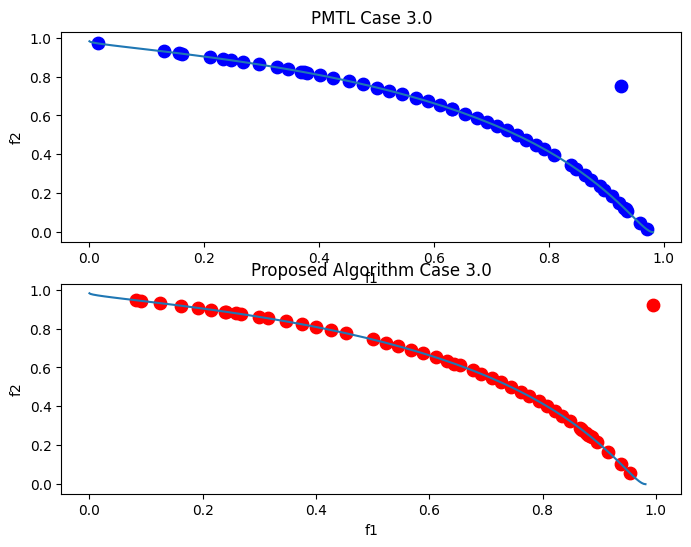

Test case  4.0
Time PMTL Test case 4.0 230.71114134788513  s
Time proposed Test case 4.0 217.56874108314514  s
Hyper volume:  1.509756567945249
Hyper volume Proposed:  1.5054654109642172


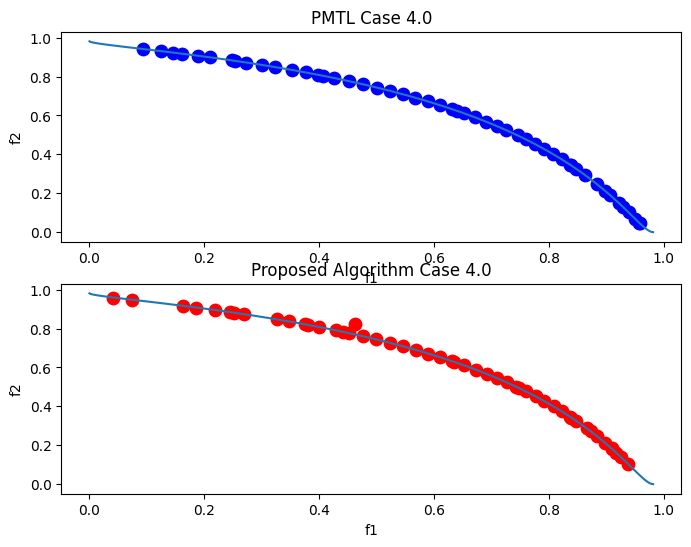

Test case  5.0
Time PMTL Test case 5.0 197.1712110042572  s
Time proposed Test case 5.0 233.87399315834045  s
Hyper volume:  1.5393099665239223
Hyper volume Proposed:  1.5153051671767601


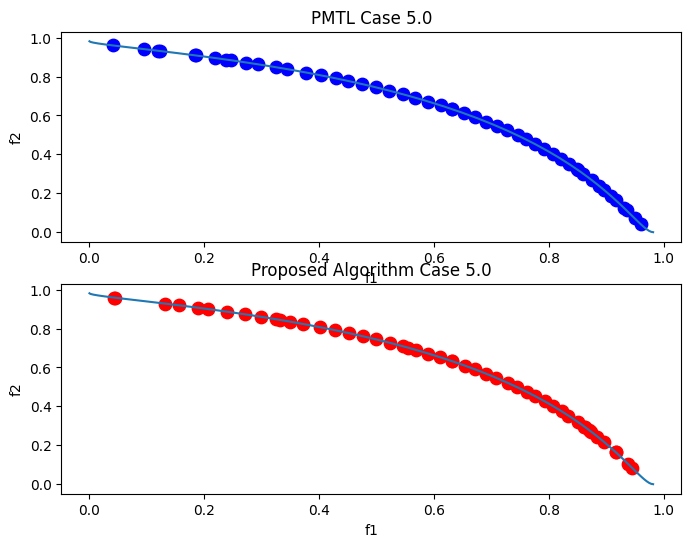

Test case  6.0
Time PMTL Test case 6.0 328.6390600204468  s
Time proposed Test case 6.0 202.14861536026  s
Hyper volume:  1.521918853460562
Hyper volume Proposed:  1.5075891508614263


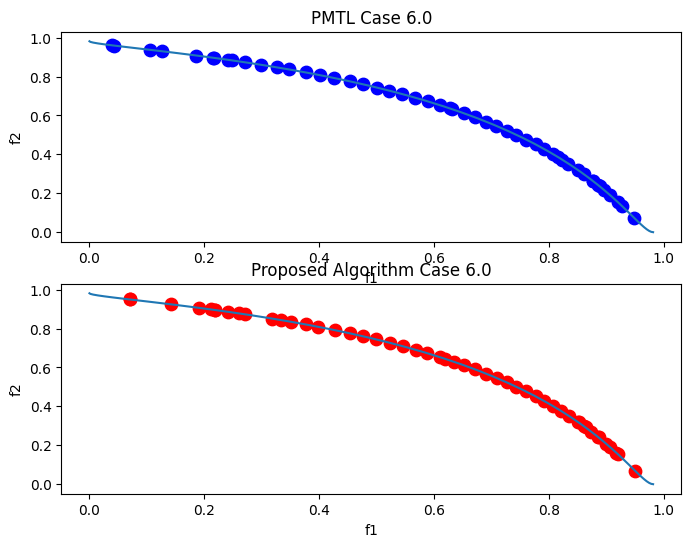

Test case  7.0
Time PMTL Test case 7.0 198.2348554134369  s
Time proposed Test case 7.0 174.02077054977417  s
Hyper volume:  1.565772089500253
Hyper volume Proposed:  1.5457485139834382


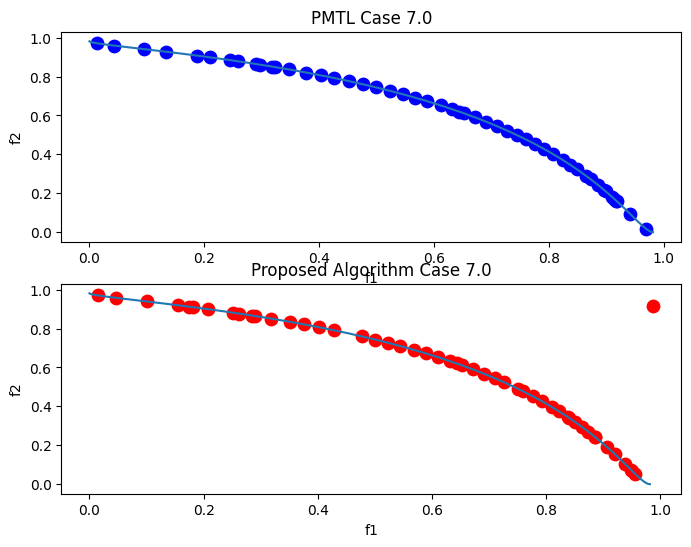

Test case  8.0
Time PMTL Test case 8.0 194.48007822036743  s
Time proposed Test case 8.0 132.81145119667053  s
Hyper volume:  1.5498004813713306
Hyper volume Proposed:  1.5663257962731745


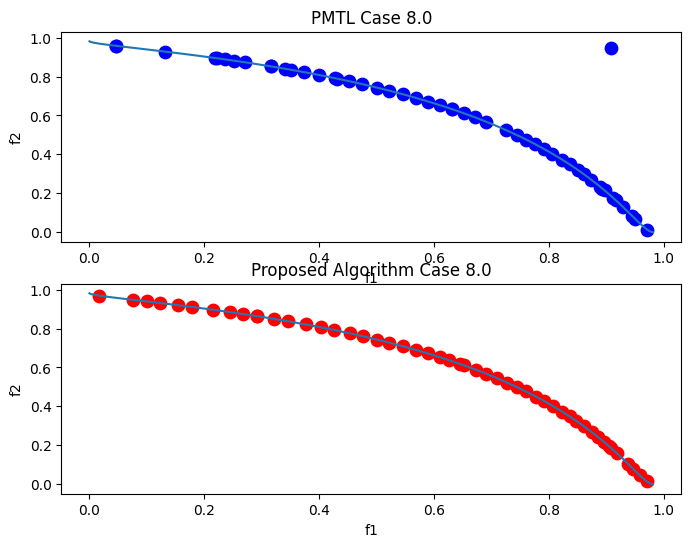

Test case  9.0
Time PMTL Test case 9.0 314.20088624954224  s
Time proposed Test case 9.0 248.35247373580933  s
Hyper volume:  1.5446017234352007
Hyper volume Proposed:  1.5528392936827753


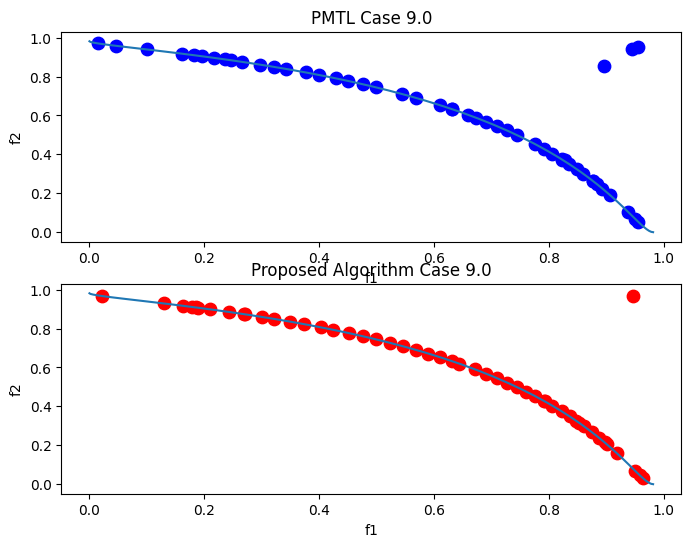

In [ ]:
def circle_points(r, n):
    # generate evenly distributed preference vector
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 0.5 * np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

# def circle_points(K, min_angle=None, max_angle=None):
#     # generate evenly distributed preference vector
#     ang0 = np.pi / 20. if min_angle is None else min_angle
#     ang1 = np.pi * 9 / 20. if max_angle is None else max_angle
#     angles = np.linspace(ang0, ang1, K, endpoint=True)
#     x = np.cos(angles)
#     y = np.sin(angles)
#     return np.c_[x, y]

def run(num = 50, num_test = 10):
    """
    run method on the synthetic example
    method: optimization method {'ParetoMTL', 'MOOMTL', 'Linear'}
    num: number of solutions
    """

    pf = create_pf_concave()

    # pf = create_pf1()
    time_value_list_proposed_full = []
    time_value_list_full = []

    HV_pros = []
    HV_PMTL = []

    f_value_list_full = []
    f_value_list_proposed_full = []

    for j in range(0,2*num_test,2):
      print('Test case ', j/2)

      f_value_list_proposed = []
      f_value_list = []
      weights = circle_points([1], [num])[0]
      fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=1)

      start_time = time()

      for i in range(num):

          # print(i)

          x, f = pareto_mtl_search(ref_vecs = weights,i = i)
          f_value_list.append(f)
      end_time = time()
      print(f'Time PMTL Test case {j/2}', end_time - start_time, ' s')
      time_value_list_full.append(end_time - start_time)

      start_time = time()
      for i in range(num):

          # print(f'Proposed', i)

          x1, f1 = pareto_mtl_search_proposed(ref_vecs = weights,i = i)
          f_value_list_proposed.append(f1)
      end_time = time()
      print(f'Time proposed Test case {j/2}', end_time - start_time, ' s')
      time_value_list_proposed_full.append(end_time - start_time)

      f_value = np.array(f_value_list)
      f_value_proposed = np.array(f_value_list_proposed)

      f_value_list_full.append(f_value)
      f_value_list_proposed_full.append(f_value_proposed)
      hv = Hypervolume(ref_point=np.array([1.5, 1.5]))
      print('Hyper volume: ',hv(f_value))
      print('Hyper volume Proposed: ',hv(f_value_proposed))
      HV_pros.append(hv(f_value_proposed))
      HV_PMTL.append(hv(f_value))
      axs[0].plot(pf[:,0],pf[:,1])
      axs[0].scatter(f_value[:,0], f_value[:,1], c = 'blue', s = 80)
      axs[0].set_xlabel("f1")
      axs[0].set_ylabel("f2")
      axs[0].set_title(f"PMTL Case {j/2}")

      axs[1].plot(pf[:,0],pf[:,1])
      axs[1].scatter(f_value_proposed[:,0], f_value_proposed[:,1], c = 'r', s = 80)
      axs[1].set_xlabel("f1")
      axs[1].set_ylabel("f2")
      axs[1].set_title(f"Proposed Algorithm Case {j/2}")

      plt.show()
    return time_value_list_proposed_full, time_value_list_full, HV_pros, HV_PMTL

time_value_list_proposed_full, time_value_list_full, HV_pros, HV_PMTL = run()

In [ ]:
with open("PMTL.txt", 'w') as output:
    for row in f_value_list_full:
        output.write(str(row) + '\n')

with open("Proposed.txt", 'w') as output:
    for row in f_value_list_proposed_full:
        output.write(str(row) + '\n')

#VD3

In [ ]:
def f3(x):
    #2 dims
    return 1/25*x[0]**2+1/100*(x[1]-9/2)**2
def f4(x):
    return 1/25*x[1]**2+1/100*(x[0]-9/2)**2

# calculate the gradients using autograd
# f1_dx = grad(f1)
# f2_dx = grad(f2)
f3_dx = grad(f3)
f4_dx = grad(f4)

def concave_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f1(x), f2(x)]), np.stack([f1_dx(x), f2_dx(x)])

def convex_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f3(x), f4(x)]), np.stack([f3_dx(x), f4_dx(x)])

### create the ground truth Pareto front ###
def create_pf_concave():
    ps = np.linspace(-1/np.sqrt(2),1/np.sqrt(2))
    pf = []

    for x1 in ps:
        #generate solutions on the Pareto front:
        x = np.array([x1,x1])

        f, f_dx = concave_fun_eval(x)
        pf.append(f)

    pf = np.array(pf)

    return pf


def create_pf1():
    ps1 = np.linspace(-6, 0, num=500)
    pf = []
    for x1 in ps1:
        x = [9*x1/(2*x1-8),9/(2-8*x1)]
        f = [f3(x), f4(x)]
        #print(f)
        pf.append(f)
    pf = np.array(pf)
    return pf

In [ ]:
# use autograd to calculate the gradient
import autograd.numpy as np
from autograd import grad
from math import e
from matplotlib import pyplot as plt
from time import time

def get_d_paretomtl(grads,value,weights,i):
    # calculate the gradient direction for Pareto MTL
    nobj, dim = grads.shape

    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight


    # solve QP
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0

    vec =  np.concatenate((grads, np.dot(w[idx],grads)), axis = 0)

    # use MinNormSolver to solve QP
    sol, nd = MinNormSolver.find_min_norm_element(vec)


    # reformulate ParetoMTL as linear scalarization method, return the weights
    weight0 =  sol[0] + np.sum(np.array([sol[j] * w[idx][j - 2,0] for j in np.arange(2,2 + np.sum(idx))]))
    weight1 = sol[1] + np.sum(np.array([sol[j] * w[idx][j - 2,1] for j in np.arange(2,2 + np.sum(idx))]))
    weight = np.stack([weight0,weight1])

    return weight


def get_d_paretomtl_init(grads,value,weights,i):
    # calculate the gradient direction for Pareto MTL initialization
    nobj, dim = grads.shape

    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight

    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0

    if np.sum(idx) <= 0:
        return np.zeros(nobj)
    if np.sum(idx) == 1:
        sol = np.ones(1)
    else:
        vec =  np.dot(w[idx],grads)
        sol, nd = MinNormSolver.find_min_norm_element(vec)

    # calculate the weights
    weight0 =  np.sum(np.array([sol[j] * w[idx][j ,0] for j in np.arange(0, np.sum(idx))]))
    weight1 =  np.sum(np.array([sol[j] * w[idx][j ,1] for j in np.arange(0, np.sum(idx))]))
    weight = np.stack([weight0,weight1])


    return weight


def circle_points(r, n):
    # generate evenly distributed preference vector
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 0.5 * np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

# def circle_points(K, min_angle=None, max_angle=None):
#     # generate evenly distributed preference vector
#     ang0 = np.pi / 20. if min_angle is None else min_angle
#     ang1 = np.pi * 9 / 20. if max_angle is None else max_angle
#     angles = np.linspace(ang0, ang1, K, endpoint=True)
#     x = np.cos(angles)
#     y = np.sin(angles)
#     return np.c_[x, y]

### the synthetic multi-objective problem ###
# def f1(x):

#     n = len(x)

#     sum1 = np.sum([(x[i] - 1.0/np.sqrt(n)) ** 2 for i in range(n)])

#     f1 = 1 - e**(- sum1)
#     return f1

# def f2(x):

#     n = len(x)

#     sum2 = np.sum([(x[i] + 1.0/np.sqrt(n)) ** 2 for i in range(n)])

#     f2 = 1 - e**(- sum2)

#     return f2



def pareto_mtl_search_proposed(ref_vecs,i,t_iter = 450, n_dim = 2, step_size = 1.5, sigma = 1, kappa = 0.9):
    """
    Pareto MTL
    """

    # randomly generate one solution
    x = np.random.uniform(-1,1,n_dim)
    #x = (np.random.rand(1,2)).tolist()[0]
    #x = np.random.uniform(-2,0,n_dim)
    #print(x.shape)
    # find the initial solution
    for t in range(int(t_iter * 0.2)):
        #f, f_dx = concave_fun_eval(x)
        f, f_dx = convex_fun_eval(x)

        weights =  get_d_paretomtl_init(f_dx,f,ref_vecs,i)

        x = x - step_size * np.dot(weights.T,f_dx).flatten()
    count =0
    # find the Pareto optimal solution
    for t in range(int(t_iter * 0.8)):
        f, f_dx = convex_fun_eval(x)
        #f, f_dx = concave_fun_eval(x)

        weights =  get_d_paretomtl(f_dx,f,ref_vecs,i)

        direction_descent = -np.dot(weights.T,f_dx).flatten()

        x = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k

        #f_after, f_dx_after = concave_fun_eval(x_next)
        f_after, f_dx_after = convex_fun_eval(x)

        if np.dot(weights.T,f_after) <= np.dot(weights.T, f) + sigma*np.dot(direction_descent.T, step_size * direction_descent):
            step_size = step_size
            count+=1
        else:
            step_size *= kappa
        if -1/2*np.linalg.norm(direction_descent, np.inf)**2 >= -1e-8 and -1/2*np.linalg.norm(direction_descent, np.inf)**2 <= 1e-8:
          break

    return x, f

def pareto_mtl_search(ref_vecs,i,t_iter = 450, n_dim = 2, step_size = 1):
    """
    Pareto MTL
    """

    # randomly generate one solution
    x = np.random.uniform(-1,1,n_dim)
    #x = (np.random.rand(1,2)).tolist()[0]
    #x = np.random.uniform(-2,0,n_dim)
    #print(x.shape)
    # find the initial solution
    for t in range(int(t_iter * 0.2)):
        #f, f_dx = concave_fun_eval(x)
        f, f_dx = convex_fun_eval(x)

        weights =  get_d_paretomtl_init(f_dx,f,ref_vecs,i)

        x = x - step_size * np.dot(weights.T,f_dx).flatten()

    # find the Pareto optimal solution
    for t in range(int(t_iter * 0.8)):
        f, f_dx = convex_fun_eval(x)
        #f, f_dx = concave_fun_eval(x)

        weights =  get_d_paretomtl(f_dx,f,ref_vecs,i)

        direction_descent = -np.dot(weights.T,f_dx).flatten()

        x = x + step_size * direction_descent

    return x, f

0
1
2
3
4
5
6
7
8
9


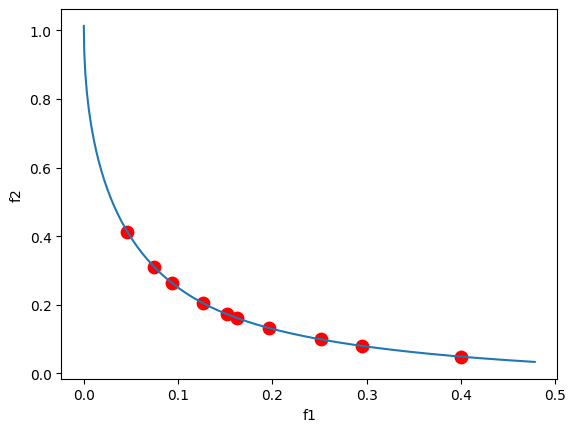

In [ ]:
pf = create_pf1()
f_value_list = []
x_value_list = []
num = 10

weights = circle_points([1], [num])[0]
#weights = circle_points2(num)

for i in range(num):

    print(i)

    x, f = pareto_mtl_search_proposed(ref_vecs = weights,i = i)

    # x = find_min(x, 2)
    # if x[0] >= 0  and x[1] >= 0 and x[0]**2 +2 *x[0]*x[1] -4 >=0:
    f_value_list.append(f)
    x_value_list.append(x)

f_value = np.array(f_value_list)
plt.xlabel("f1")
plt.ylabel("f2")
plt.plot(pf[:,0],pf[:,1])
plt.scatter(f_value[:,0], f_value[:,1], c = 'r', s = 80)
plt.show()

Test case  0.0
Time PMTL Test case 0 982.1384408473969  s
Time proposed Test case 0 996.1148252487183  s
Hyper volume:  0.982108075233558
Hyper volume Proposed:  1.0221128530651482


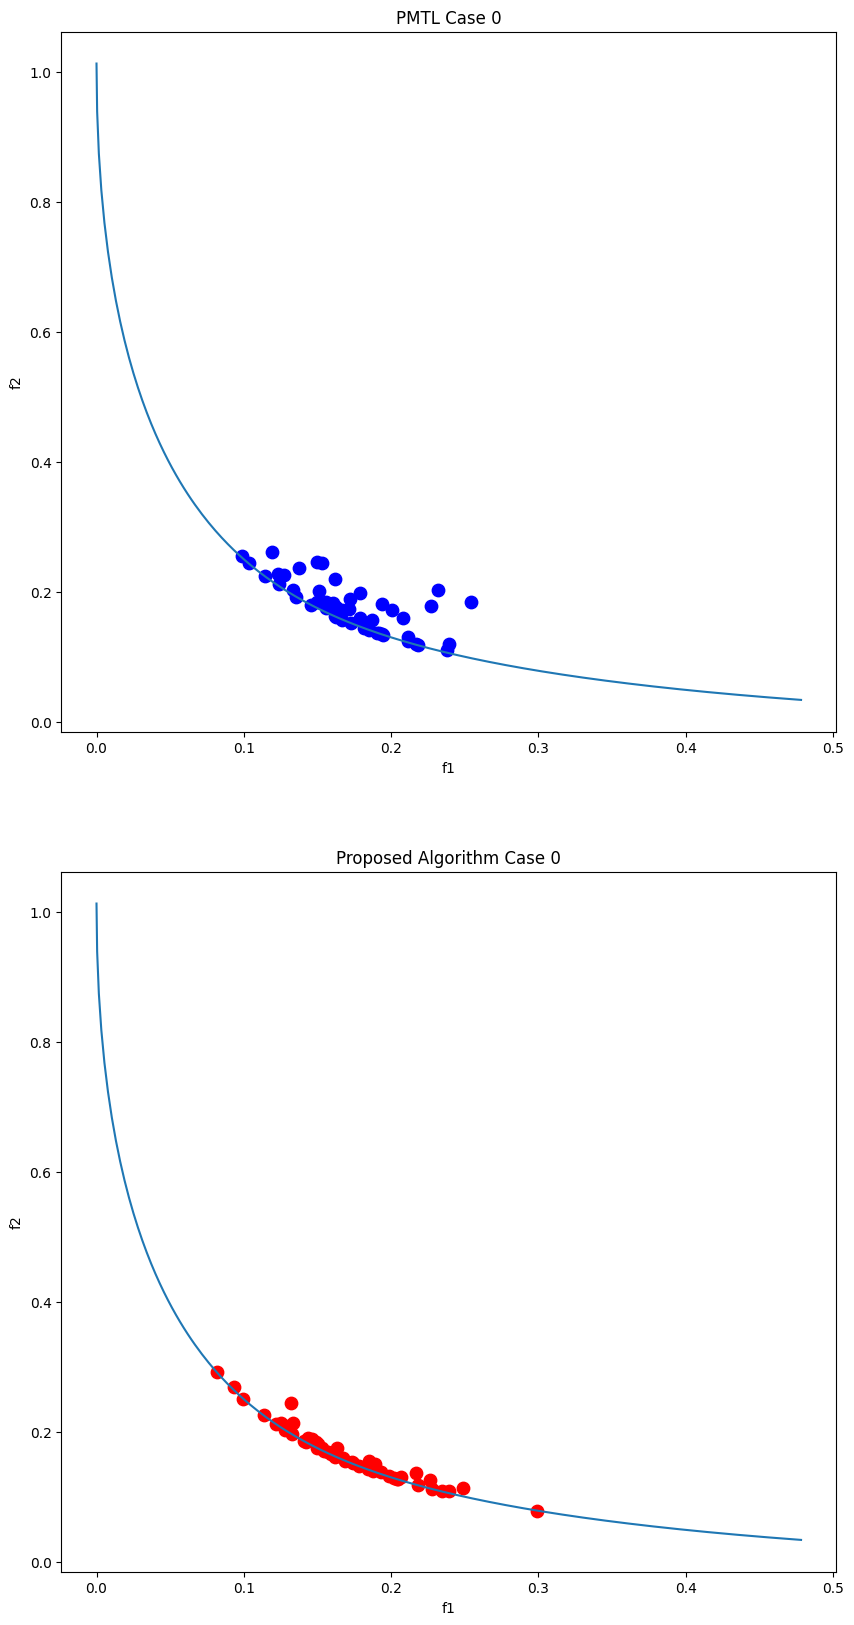

Test case  1.0
Time PMTL Test case 2 926.4262363910675  s
Time proposed Test case 2 809.2733662128448  s
Hyper volume:  1.0193524399854081
Hyper volume Proposed:  1.0111124524091366


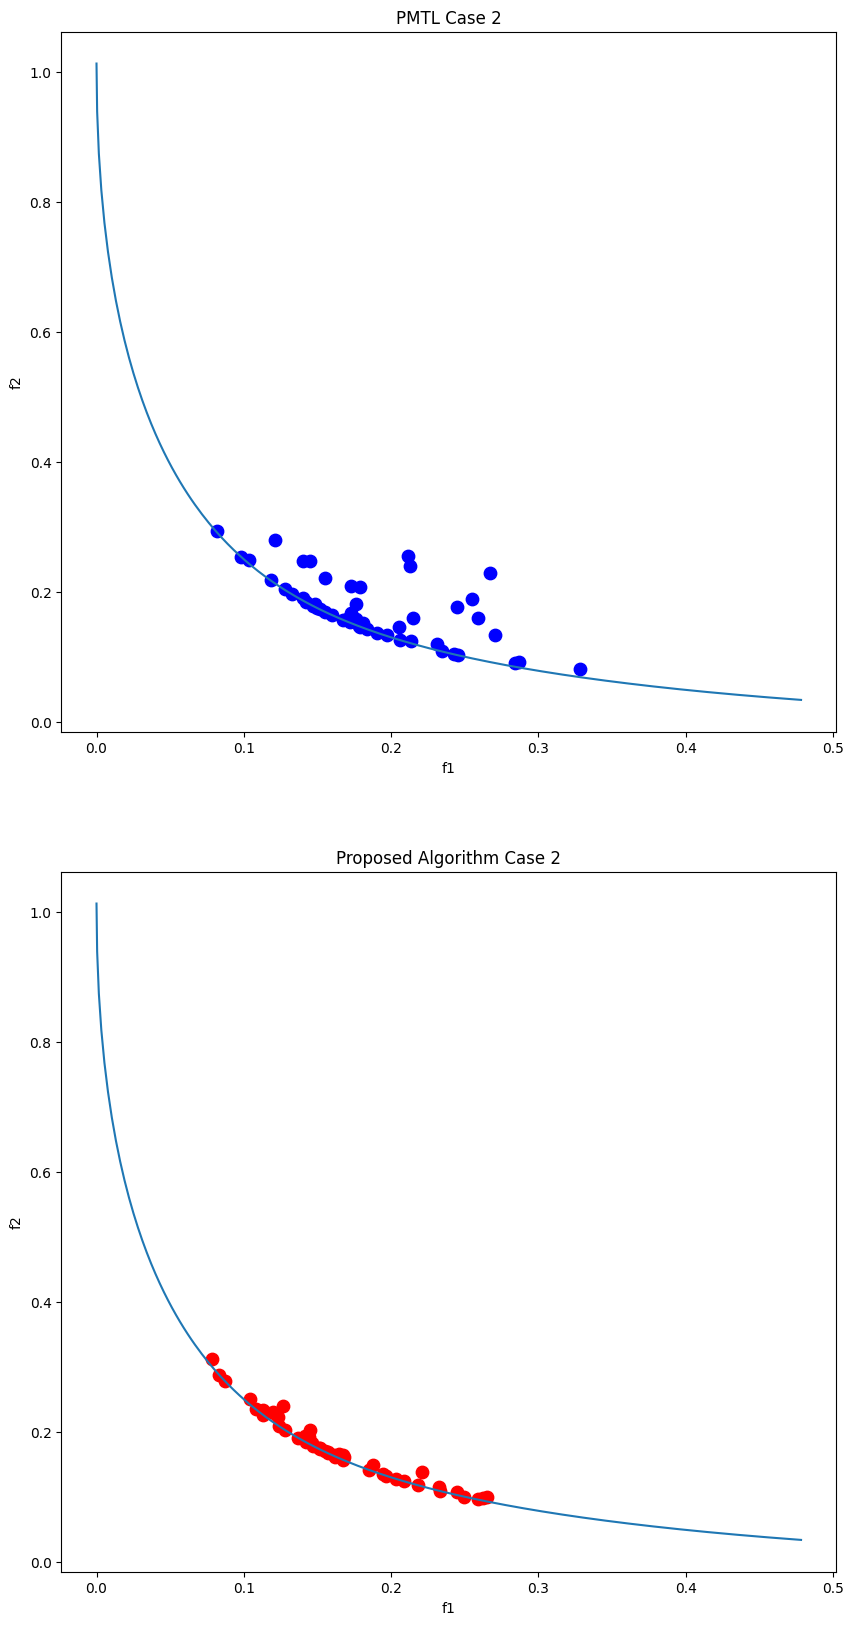

Test case  2.0
Time PMTL Test case 4 1375.7180182933807  s
Time proposed Test case 4 923.0057256221771  s
Hyper volume:  1.0044614084859558
Hyper volume Proposed:  1.0061140888740832


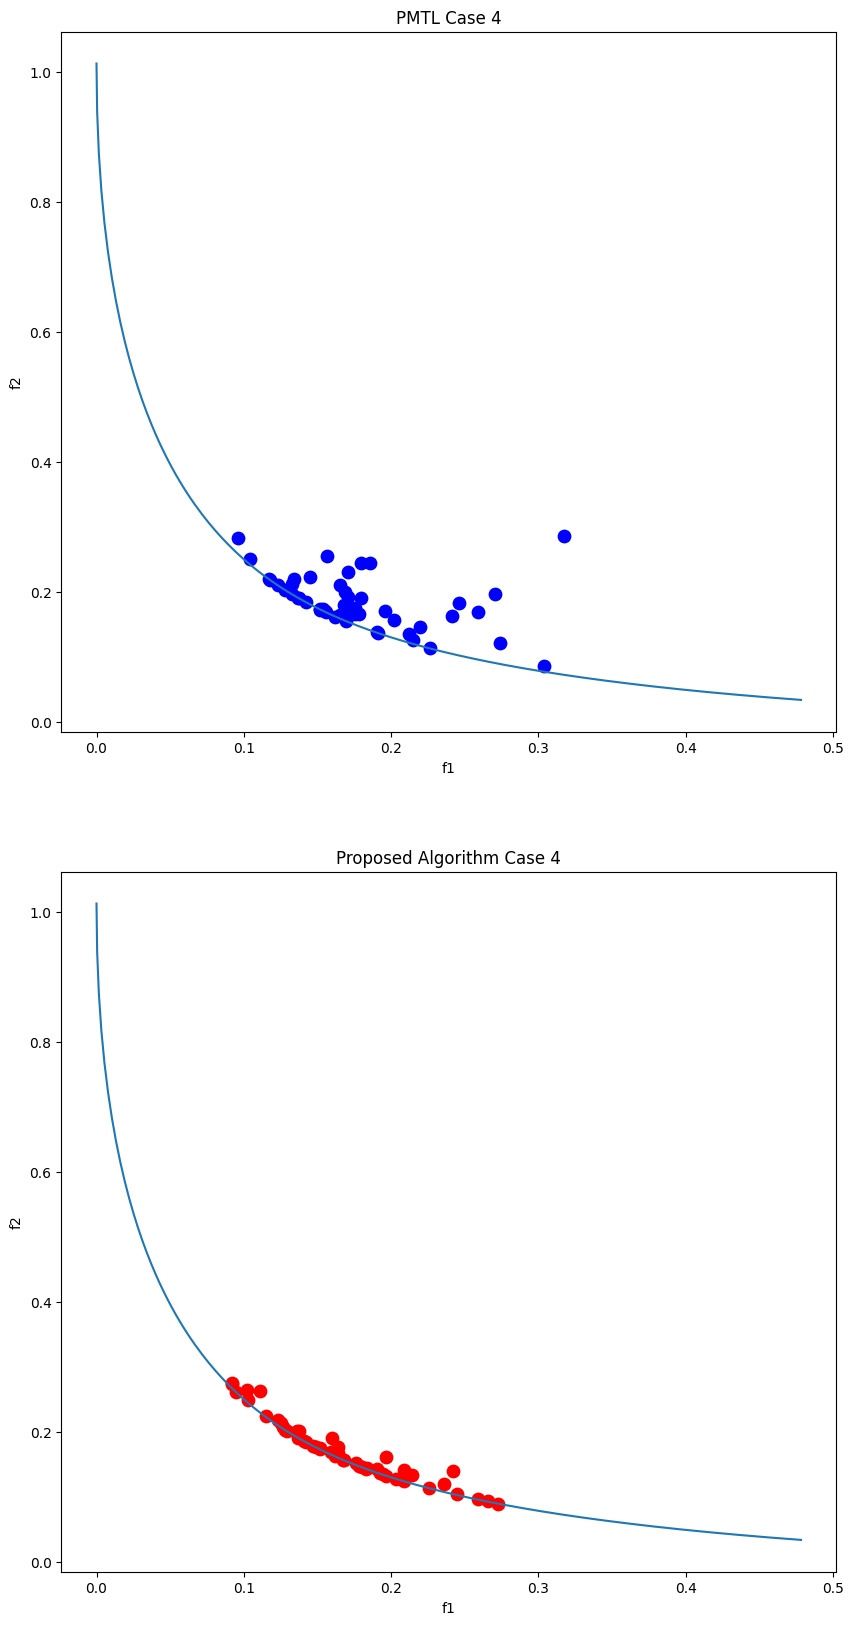

Test case  3.0
Time PMTL Test case 6 1027.669021844864  s
Time proposed Test case 6 947.333705663681  s
Hyper volume:  0.9914182379281253
Hyper volume Proposed:  1.009771271453523


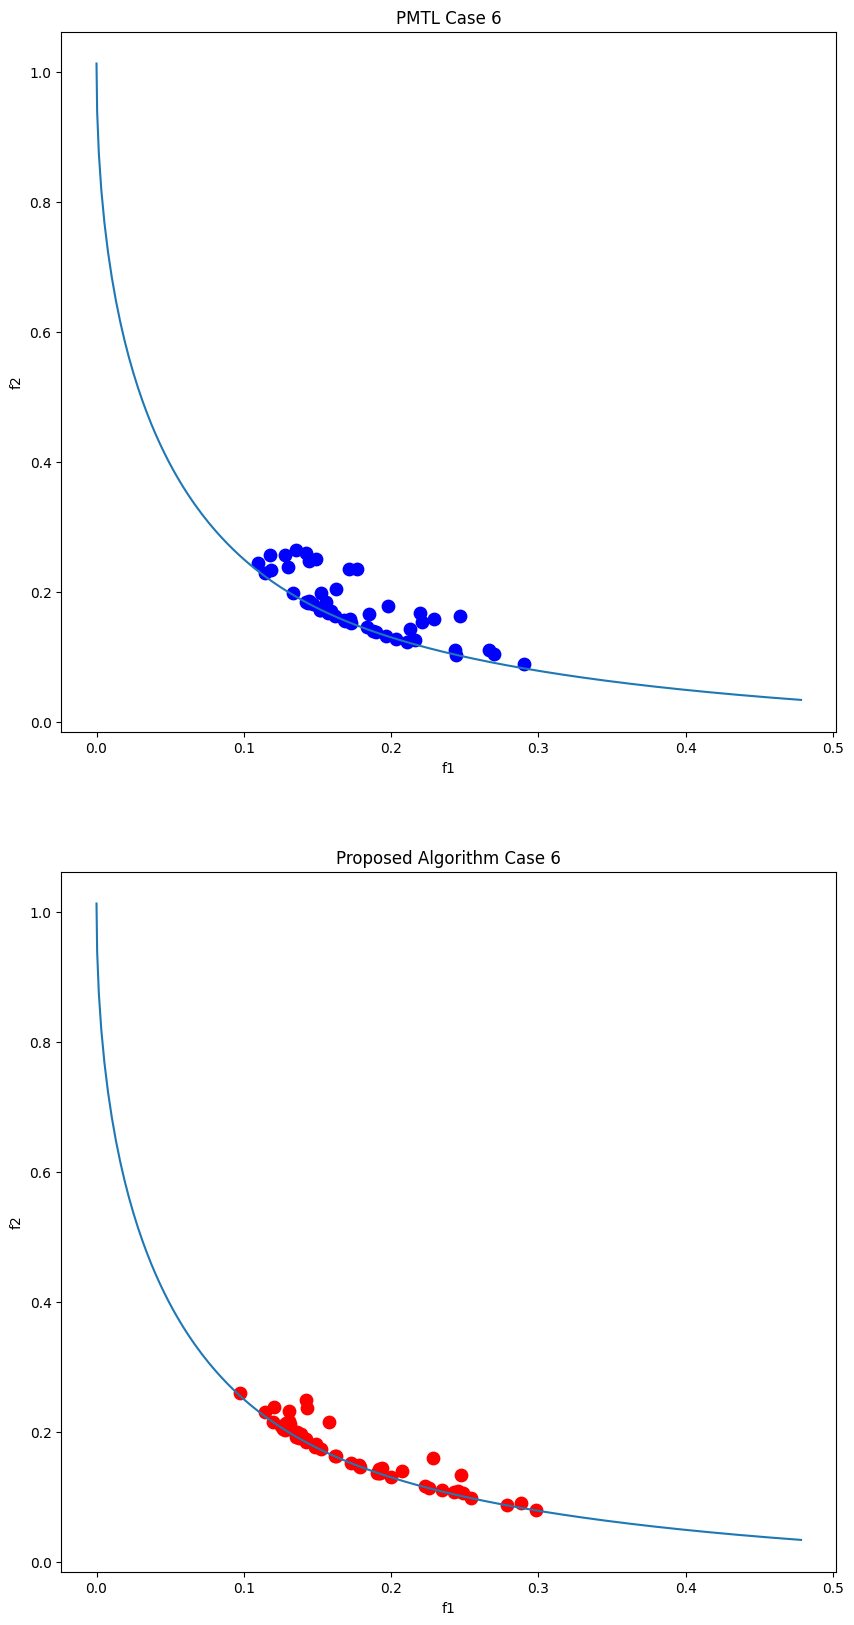

Test case  4.0
Time PMTL Test case 8 1048.4235706329346  s
Time proposed Test case 8 969.7423248291016  s
Hyper volume:  1.006609465007459
Hyper volume Proposed:  1.0181431844736835


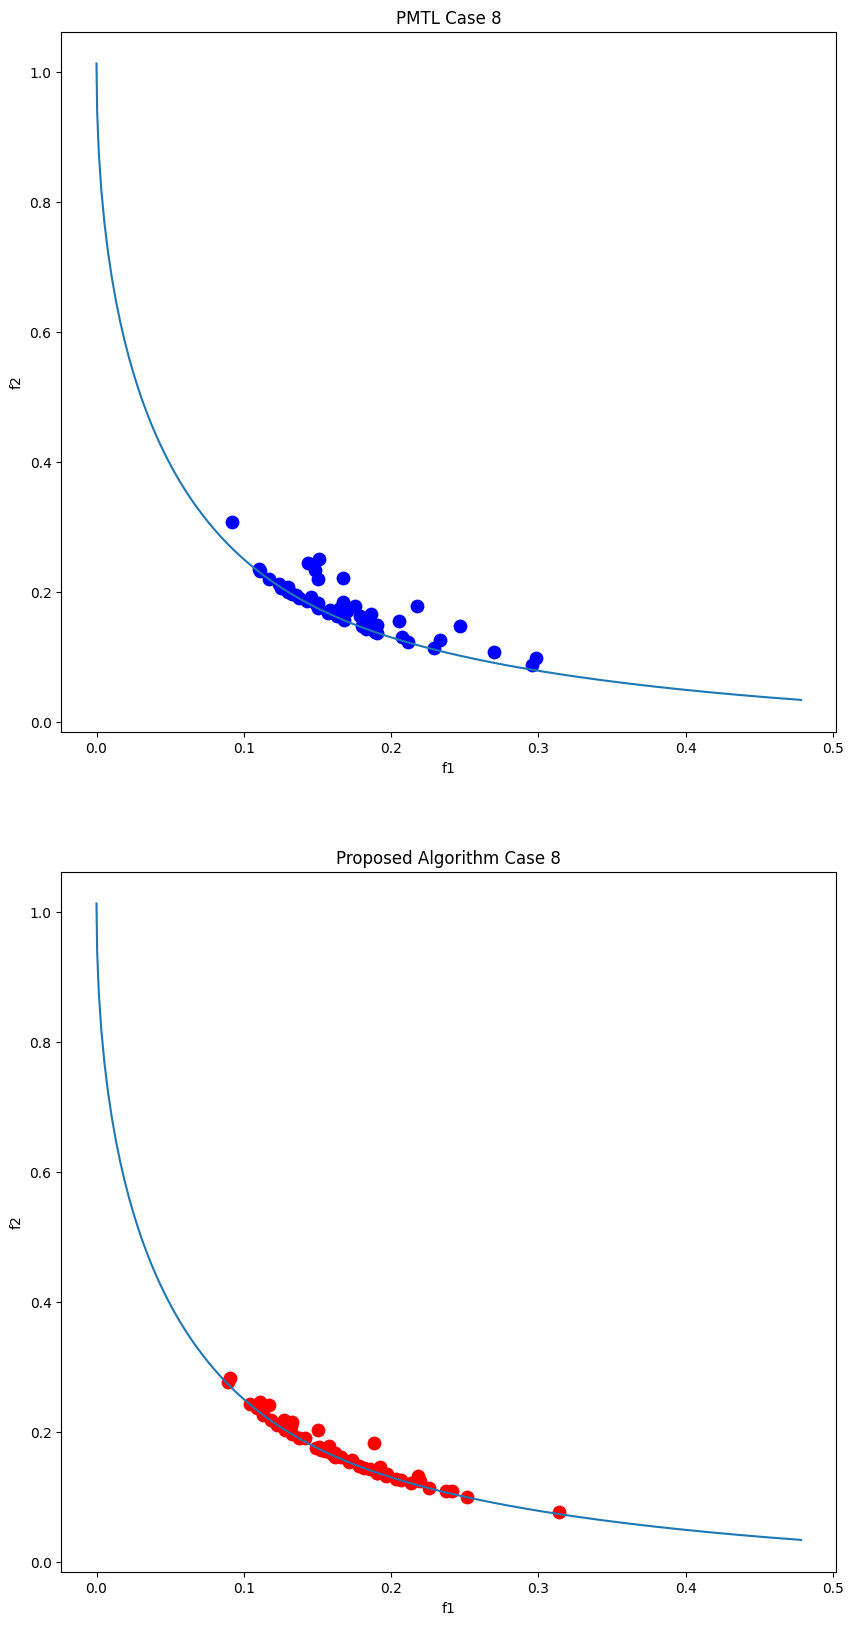

Test case  5.0
Time PMTL Test case 10 973.0129308700562  s
Time proposed Test case 10 1019.984260559082  s
Hyper volume:  1.0065816194242074
Hyper volume Proposed:  1.0128296527523726


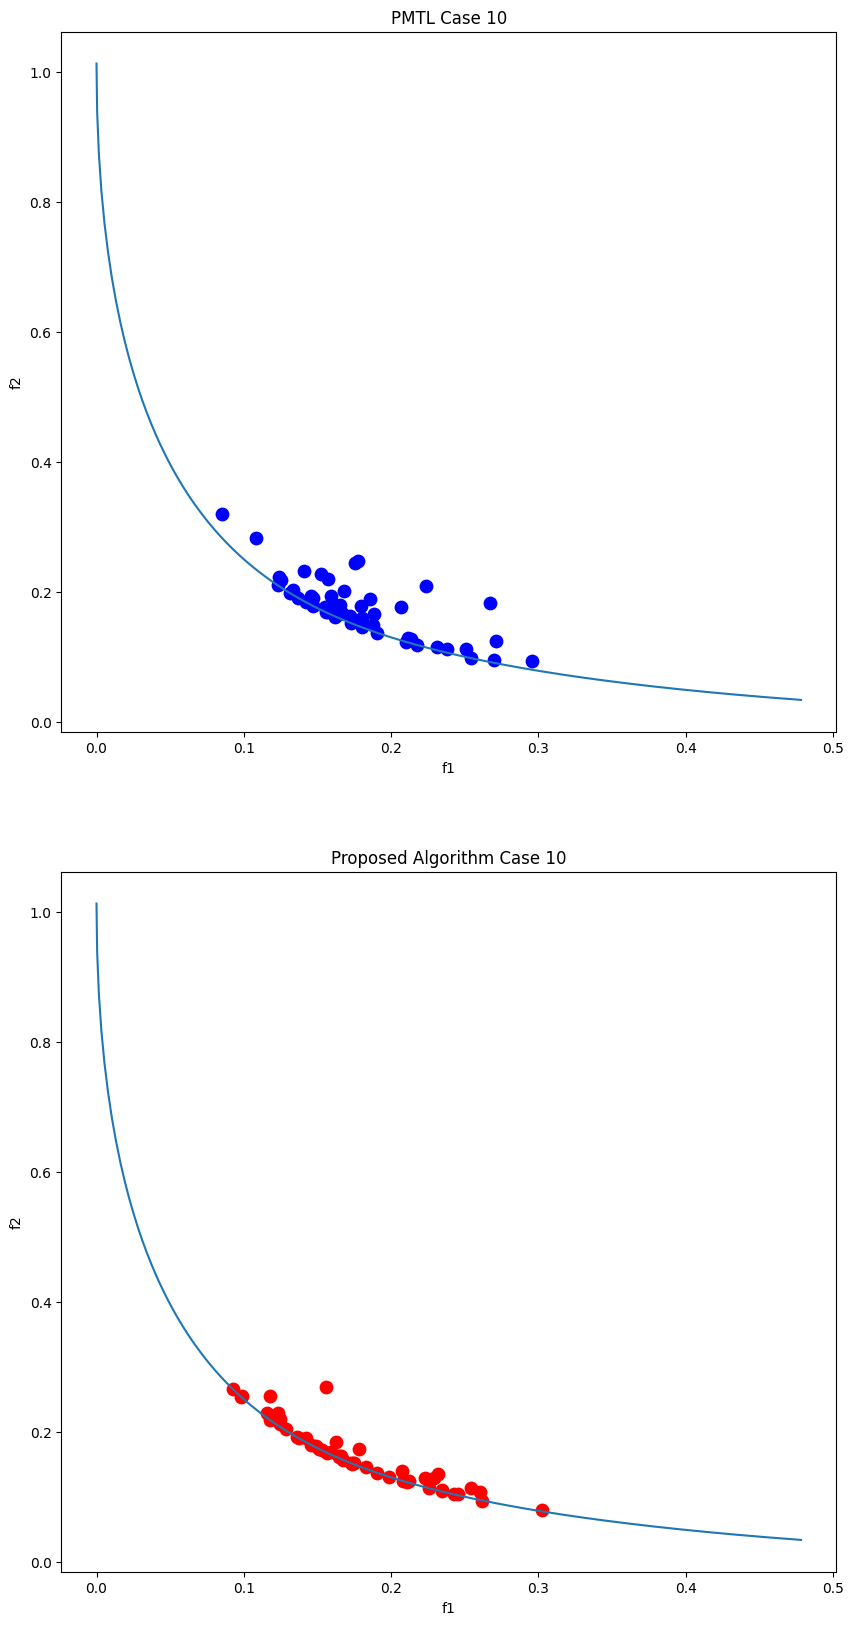

Test case  6.0
Time PMTL Test case 12 966.6431365013123  s
Time proposed Test case 12 864.6074676513672  s
Hyper volume:  1.0059114706963401
Hyper volume Proposed:  1.0146895678651553


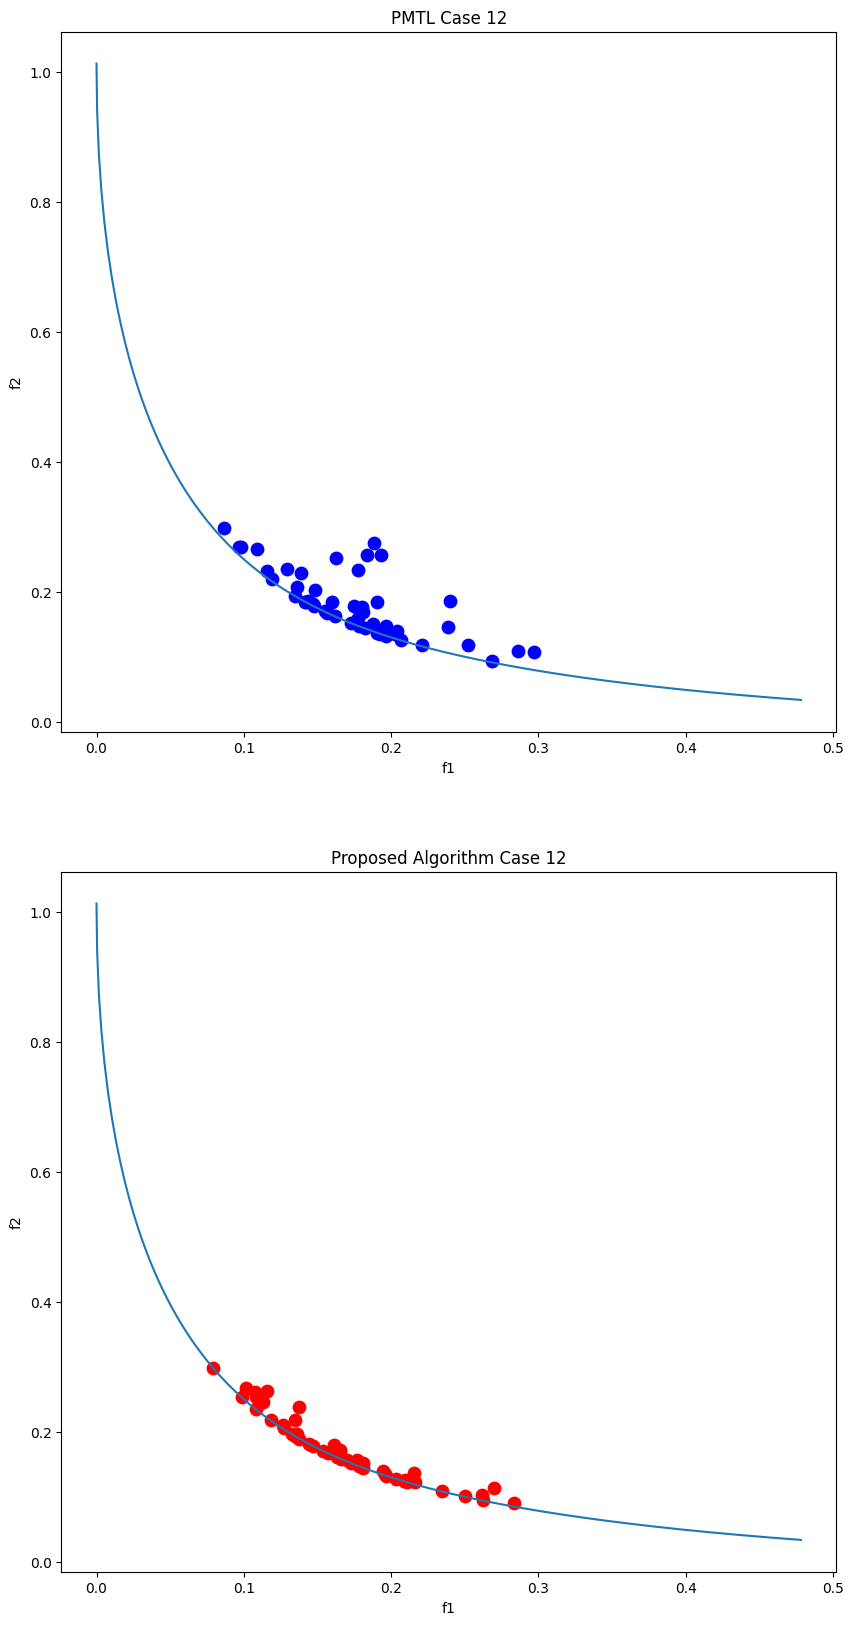

Test case  7.0
Time PMTL Test case 14 1217.1447837352753  s
Time proposed Test case 14 793.962671995163  s
Hyper volume:  0.9975463508887845
Hyper volume Proposed:  1.0177091132849547


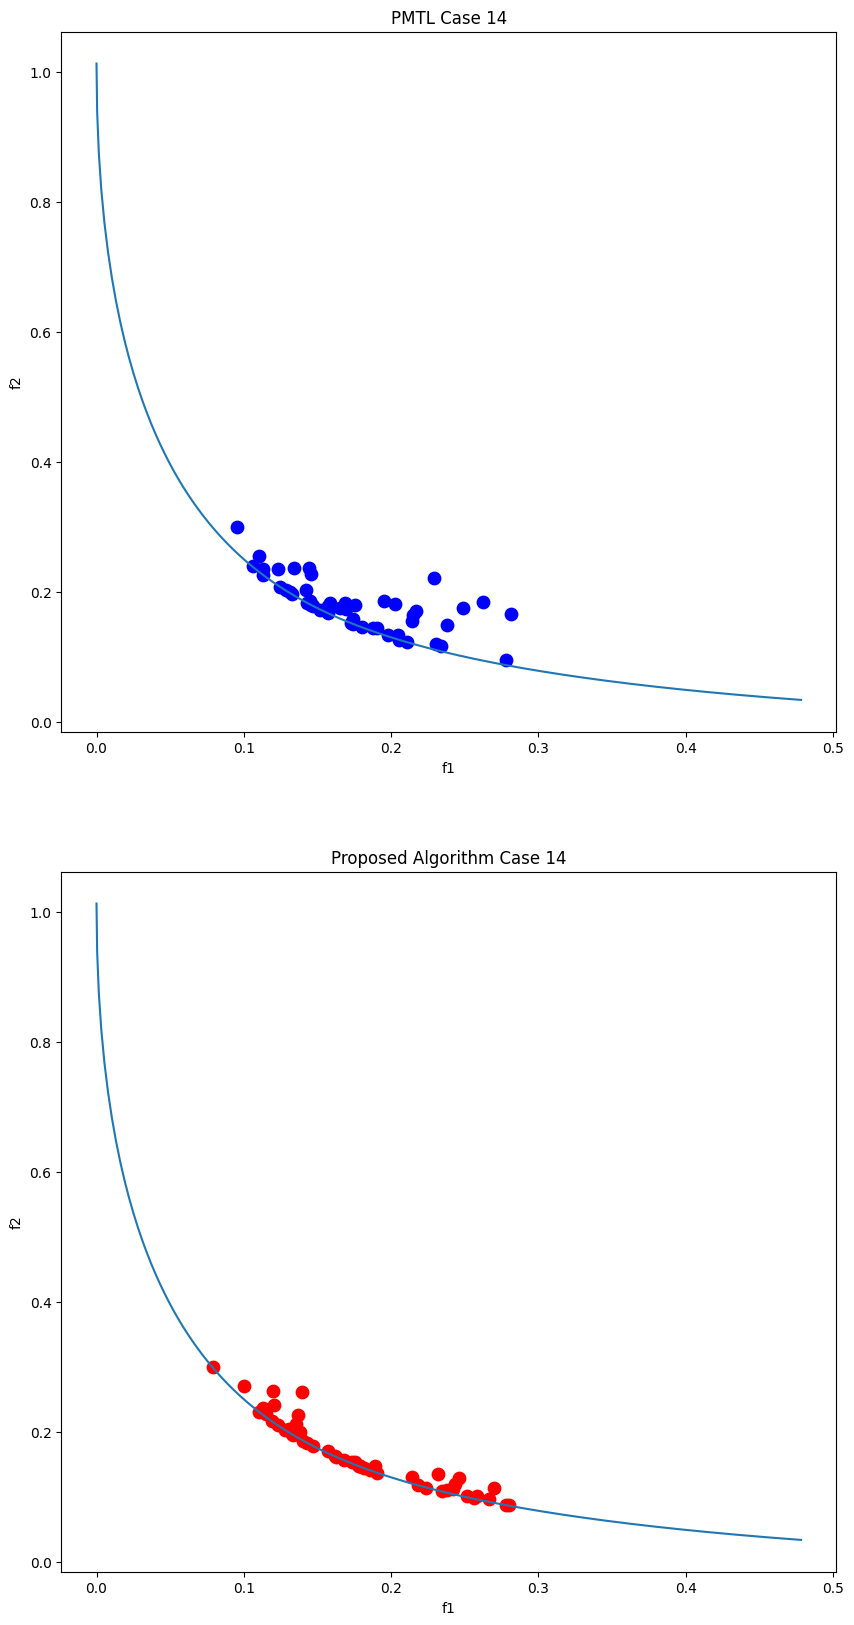

In [ ]:
def run(num = 50, n_dim = 2, num_test = 8):
    """
    run method on the synthetic example
    method: optimization method {'ParetoMTL', 'MOOMTL', 'Linear'}
    num: number of solutions
    """

    #pf = create_pf_concave()


    pf = create_pf1()
    f_value_list_proposed_full = []
    f_value_list_full = []

    for j in range(0,2*num_test,2):
      print('Test case ', j/2)

      f_value_list_proposed = []
      f_value_list = []
      weights = circle_points([1], [num])[0]
      fig, axs = plt.subplots(figsize=(10, 20), nrows=2, ncols=1)

      start_time = time()
      for i in range(num):

          # print(i)

          x, f = pareto_mtl_search(ref_vecs = weights,i = i)
          f_value_list.append(f)
      end_time = time()
      print(f'Time PMTL Test case {j}', end_time - start_time, ' s')

      start_time = time()
      for i in range(num):

          # print(f'Proposed', i)

          x1, f1 = pareto_mtl_search_proposed(ref_vecs = weights,i = i)
          f_value_list_proposed.append(f1)
      end_time = time()
      print(f'Time proposed Test case {j}', end_time - start_time, ' s')

      f_value = np.array(f_value_list)
      f_value_proposed = np.array(f_value_list_proposed)

      f_value_list_full.append(f_value)
      f_value_list_proposed_full.append(f_value_proposed)
      hv = Hypervolume(ref_point=np.array([1.1, 1.1]))
      print('Hyper volume: ',hv(f_value))
      print('Hyper volume Proposed: ',hv(f_value_proposed))
      axs[0].plot(pf[:,0],pf[:,1])
      axs[0].scatter(f_value[:,0], f_value[:,1], c = 'blue', s = 80)
      axs[0].set_xlabel("f1")
      axs[0].set_ylabel("f2")
      axs[0].set_title(f"PMTL Case {j}")

      axs[1].plot(pf[:,0],pf[:,1])
      axs[1].scatter(f_value_proposed[:,0], f_value_proposed[:,1], c = 'r', s = 80)
      axs[1].set_xlabel("f1")
      axs[1].set_ylabel("f2")
      axs[1].set_title(f"Proposed Algorithm Case {j}")

      plt.show()
    return f_value_list_full, f_value_list_proposed_full
f_value_list_full, f_value_list_proposed_full = run()

In [ ]:
with open("/content/drive/MyDrive/Result/Synthetic/VD2/PMTL.txt", 'w') as output:
    for row in f_value_list_full:
        output.write(str(row) + '\n')

with open("/content/drive/MyDrive/Result/Synthetic/VD2/Proposed.txt", 'w') as output:
    for row in f_value_list_proposed_full:
        output.write(str(row) + '\n')